# Project Proposal Group 33


### Predicting a Tennis Player's Best Rank Based on Their Age, Seasons Played, Current Rank, and Prize Money

### Introduction


Tennis is a popular sport with a history of competitive tournaments and rankings. Tennis player rankings are essential to evaluate their performance but predicting a player's best rank can be difficult. This project aims to use K-nearest neighbor regression to predict a player's best rank based on age, seasons played, current rank, and prize money. The dataset will be analyzed using five-fold cross-validation, and visualization techniques such as scatter plots will provide insight into factors that influence ranking.

### Preliminary Data Analysis


In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The seed value is set to 4321 to enusre that every random process yields the same oucome when the code reruns.

In [3]:
set.seed(4321)

In [4]:
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis_data <- read_csv(url)
head(tennis_data, n=10)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,28 (18-11-1991),United States,Right-handed,Wikipedia,307 (131),213 (31-10-2016),Sekou Bangoura,Two-handed,"$278,709",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,21 (12-05-1998),"Taiwan, Province of China",Right-handed,Wikipedia,232 (205),229 (04-11-2019),Tung Lin Wu,Two-handed,"$59,123",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,25 (29-07-1994),Uzbekistan,Right-handed,Wikipedia,417 (81),253 (17-07-2017),Sanjar Fayziev,Two-handed,"$122,734",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


For our project we chose the columns Age, Best Rank, Prize Money, Current Rank, and Seasons. These predictors were selected because they contain the most data compared to other columns which mostly contain N/As and all these variables have a direct or indirect impact on a player's performance.

We also isolated our desired variables, deleted empty observations, and removed unnecessary characters such as the unnecessary strings in the Prize Money varaible.

In [5]:
colnames(tennis_data) <- make.names(colnames(tennis_data))
tennis_data_separated <- tennis_data |> select(Age, Best.Rank, Prize.Money, Seasons, Current.Rank) |>
                separate(col = Age,
                        into = c("Age", "date"),
                        sep=" ",
                        convert=TRUE) |>
                separate(col = Best.Rank,
                        into = c("best_rank", "date_rank"),
                        sep=" ",
                        convert=TRUE) |>

                separate(col = Current.Rank,
                        into = c("current_rank", "date_cur_rank"),
                        sep=" ",
                        convert=TRUE) |>
    select(Age, best_rank, current_rank, Prize.Money, Seasons)

head(tennis_data_separated, n = 10)

Age,best_rank,current_rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,"$59,040",NA
32,44,178,"US$3,261,567",14
21,130,236,"$374,093",2
27,17,183,"US$6,091,971",11
22,31,31,"$1,517,157",5
28,213,307,"$278,709",1
21,229,232,"$59,123",1
25,253,417,"$122,734",5


In [6]:
tennis_data_separated$Prize.Money <- gsub("US", " ", tennis_data_separated$Prize.Money)


tennis_data_separated$Prize.Money <- gsub("US", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("all-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("11th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("10th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("14th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("27th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("15th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("30th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("All-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("4th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("28th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("2nd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("6th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("33rd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("26th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("48th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("41st", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("\\$","", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("   ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("  ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" all-time in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub(",", "", tennis_data_separated$Prize.Money)

tennis_data_renamed <- tennis_data_separated |>
    rename("Best_Rank" = "best_rank") |>
    rename("Current_Rank" = "current_rank")
head(tennis_data_renamed, n = 10)

Age,Best_Rank,Current_Rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,59040,NA
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5


We also converted the Prize Money column from character into double.

In [7]:
tennis_data_mutated <- tennis_data_renamed |>
    mutate(Prize_Money = as.numeric(Prize.Money)) |>
    na.omit() |>
    select(Age, Best_Rank, Current_Rank, Prize_Money, Seasons)

head(tennis_data_mutated, n = 10)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5
20,104,104,74927,3
19,17,22,1893476,3


We split the data into 75% training and 25% testing datasets with starta set to  our target variable (Best_Rank). We will use the training set to train the model and the testing set to assess its accuracy. 

In [8]:
tennis_data_split <- initial_split(tennis_data_mutated, prop = .75, strata = Best_Rank)
tennis_data_train <- training(tennis_data_split)
tennis_data_test <- testing(tennis_data_split)
head(tennis_data_train, n = 10)
head(tennis_data_test, n = 10)

Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
27,17,183,6091971,11
22,31,31,1517157,5
19,17,22,1893476,3
23,4,4,10507693,5
31,3,121,25889586,14
22,25,34,2722314,6
33,19,130,10821168,14
32,11,45,11912152,15
32,9,12,13470614,16


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
21,130,236,374093,2
25,253,417,122734,5
22,238,432,62529,1
35,18,85,10581476,18
27,11,14,7217264,8
27,26,41,3062847,11
26,99,99,709278,7
22,335,440,89281,1
33,1,1,119601561,19


In [9]:
tennis_data_train_mean <- tennis_data_train |> map_df(mean)
tennis_data_train_median <- tennis_data_train |> map_df(median)

print("Training Tennis Data Mean")
tennis_data_train_mean
print("Training Tennis Data Median")
tennis_data_train_median

[1] "Training Tennis Data Mean"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27.0625,127.7684,207.9154,3861066,6.713235


[1] "Training Tennis Data Median"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27,99,196.5,645079,5


The tables above show that the data needs to be standardized since our predictors have very different ranges and we do not want the predictors with larger sclaes (such as Prize_Money) to have a greater effect on our model than the ones with smaller scales (such as Seasons). We can also observe that Prize_Money has a much larger mean value compared to is median value which could point to potential outliers that are boosting the avarage and skewing the distribution which again suggests we should standardize our data.


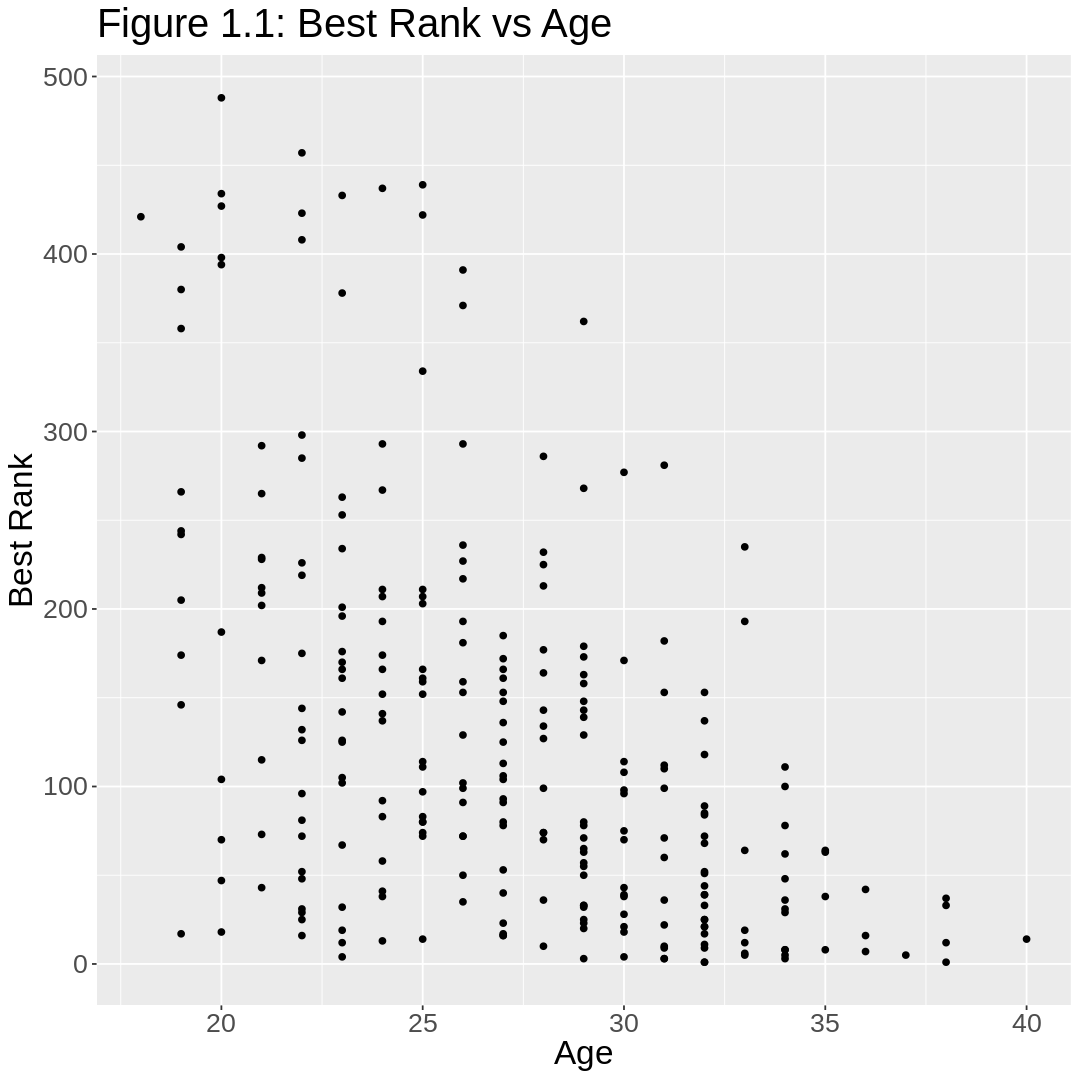

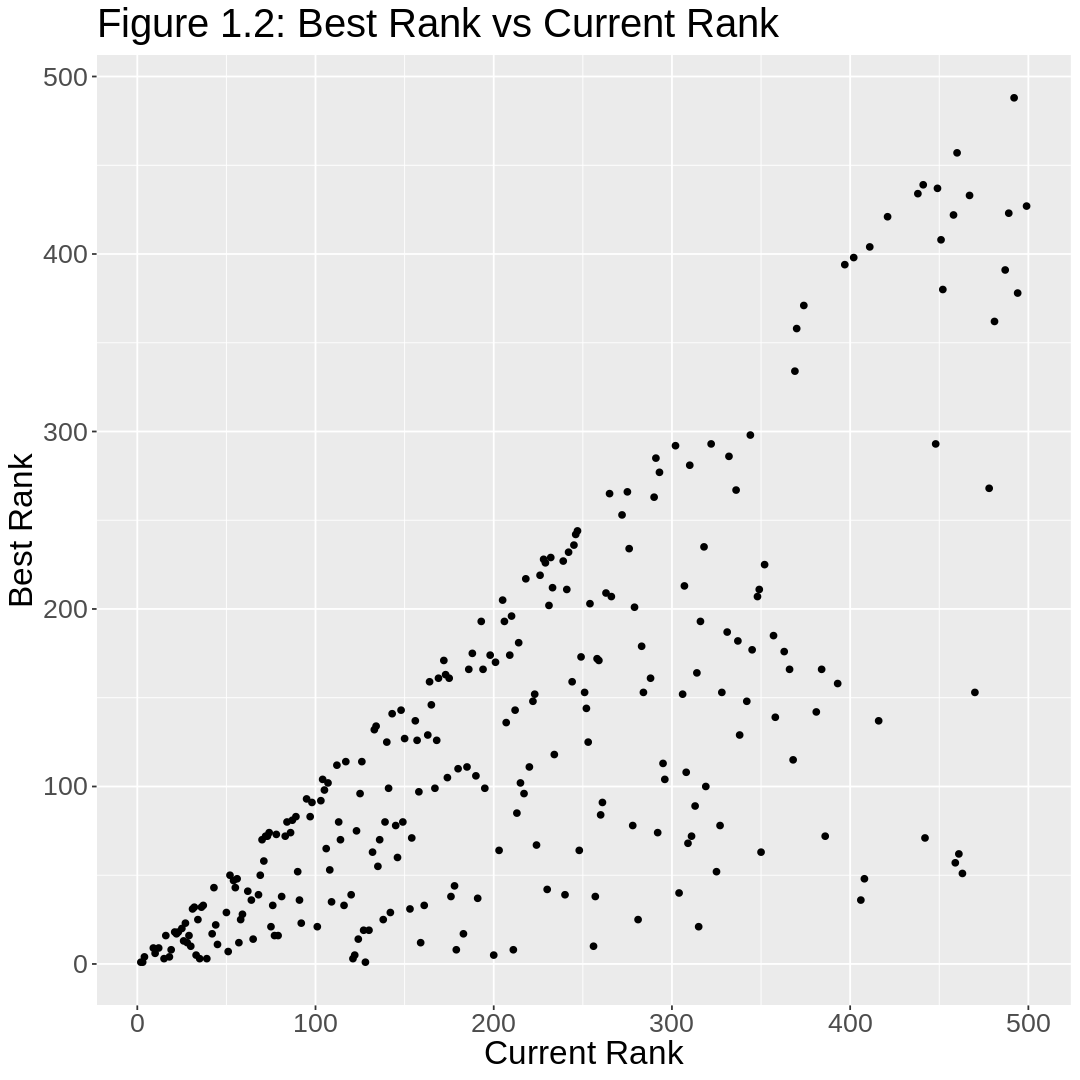

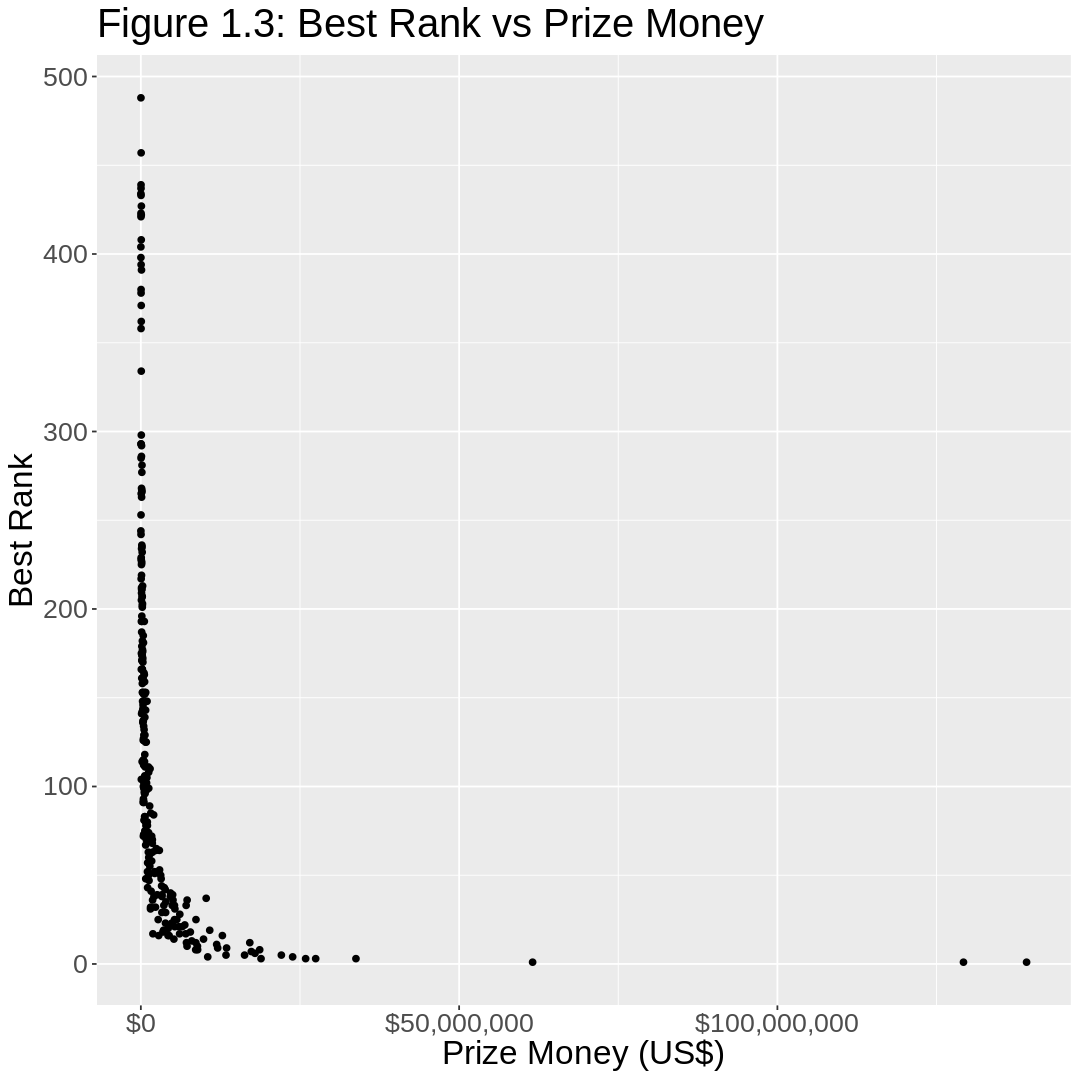

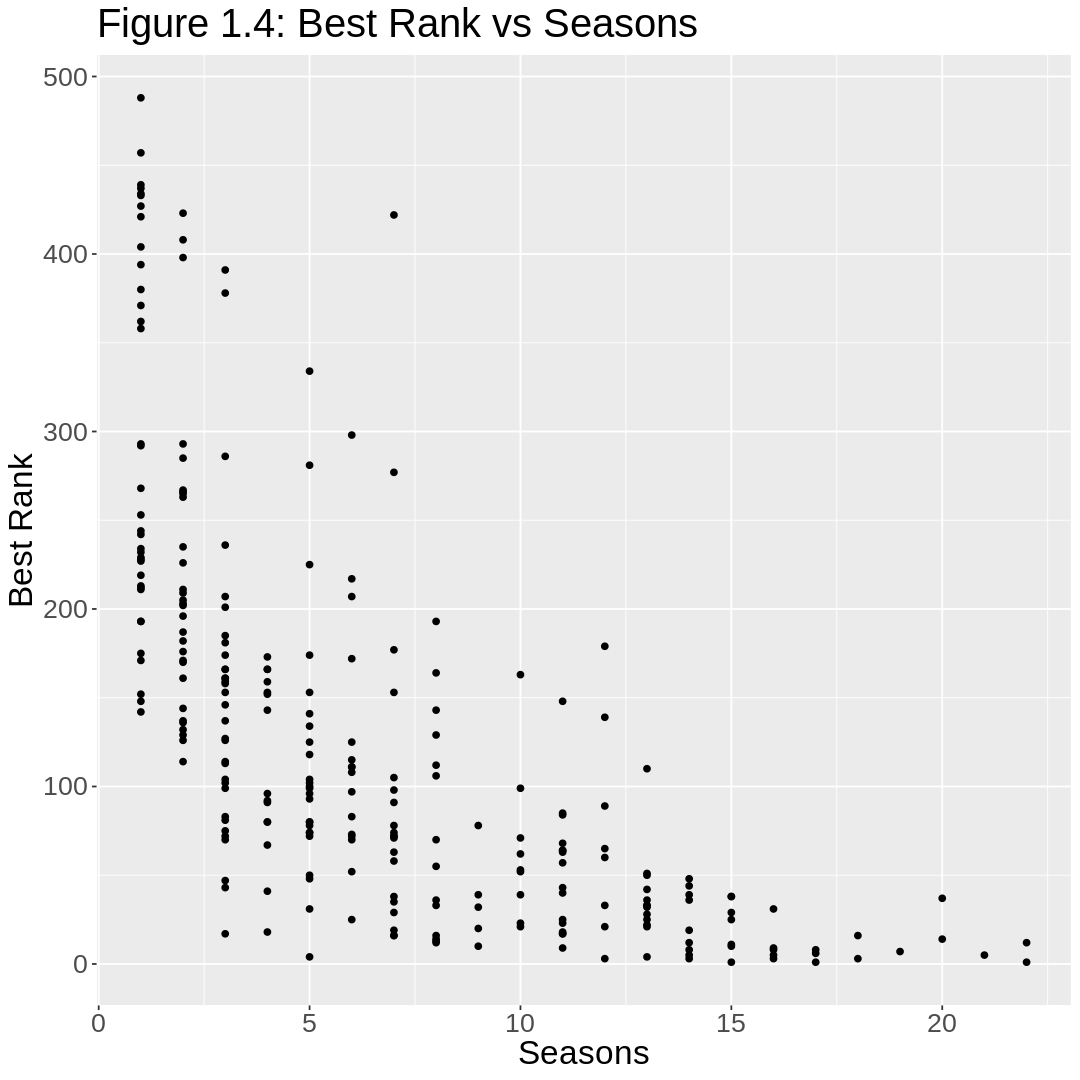

In [11]:
options(repr.plot.width = 9, repr.plot.height = 9)
ggplot(tennis_data_train, aes(x = Age, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.1: Best Rank vs Age", x = "Age", y = "Best Rank") +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Current_Rank, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.2: Best Rank vs Current Rank", x = "Current Rank", y = "Best Rank") +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Prize_Money, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.3: Best Rank vs Prize Money", x = "Prize Money (US$)", y = "Best Rank") +
    scale_x_continuous(labels = dollar_format()) +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Seasons, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.4: Best Rank vs Seasons", x = "Seasons", y = "Best Rank") +
    theme(text = element_text(size = 20))

As seen from the plots above, Age and Best Rank have a weak negative linear relationship which suggests that statistically, age has an impact on a player's best rank, which is why we chose this predictor. Furthermore, Best Rank and Current Rank have a strong positive linear relationship which indicates that a player's Current Rank influences their projected Best Rank. We also noted that Current Rank can never be numerically lower than the Best Rank. Moreover, Best Rank and Prize Money have a negative exponential relationship, meaning that only the highest ranking players are winning extremely large sums; as a player's rank decreases as their winnings increase. There is also a weak exponential decay relationship between Best Rank and Seasons which indicates that the more seasons a player has played, the more likely they are to have a lower rank. All of these variables have a distinct influence on the Best Rank which is why we chose as our predictors in our model.

### Methods

Since we need to standardize the data before any further analysis, we will begin by making a recipe that contains all predictor variables (tennis_data_recipe) as well as four other recipes for each of the predictors individually. Each recipe will scale and center all the predictors in the model.  

In [38]:
tennis_data_recipe <- recipe(Best_Rank ~ Age + Current_Rank + Prize_Money + Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_age <- recipe(Best_Rank ~ Age, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_cr <- recipe(Best_Rank ~ Current_Rank, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_pm <- recipe(Best_Rank ~ Prize_Money + Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_seasons <- recipe(Best_Rank ~ Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

Next me create our KNN regression model, setting neighbors to tune() to find the optimal value of k.

In [39]:
tennis_data_specs <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_data_specs

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Model 1: Age as the only predictor

Now we make the workflow for the model  using the tennis_data_specs and tennis_data_recipe_age which will only use age as the predictor variable.

In [41]:
tennis_data_workflow_age <- workflow() |>
    add_recipe(tennis_data_recipe_age) |>
    add_model(tennis_data_specs)

tennis_data_workflow_age

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now in order to find the optimal value for k for this model, we will use a five fold cross validation with paramater values from 1 to 100.

In [42]:
tennis_data_vfold <- vfold_cv(tennis_data_train, v = 5, strata = Best_Rank)

gridvals <- tibble <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

age_result <- tennis_data_workflow_age |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(age_result, n= 10)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,143.36150,5,7.294908,Preprocessor1_Model01
3,rmse,standard,125.90398,5,6.413098,Preprocessor1_Model02
5,rmse,standard,119.41662,5,7.076842,Preprocessor1_Model03
7,rmse,standard,111.71748,5,6.352577,Preprocessor1_Model04
9,rmse,standard,106.53897,5,5.720072,Preprocessor1_Model05
11,rmse,standard,104.07085,5,5.384854,Preprocessor1_Model06
13,rmse,standard,101.57428,5,5.266233,Preprocessor1_Model07
15,rmse,standard,101.47391,5,5.306309,Preprocessor1_Model08
17,rmse,standard,99.97277,5,5.819149,Preprocessor1_Model09


We will select the number of neighbors that coincides with the lowest estiamte RMSE since we want the lowest RMSPE.

In [16]:
kmin_age_df <- age_result |>
    filter(mean == min(mean))

kmin_age <- kmin_age_df |>
    pull(neighbors)

kmin_age_df
kmin_age

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
53,rmse,standard,96.8146,5,2.590385,Preprocessor1_Model27


Now we use k = 53 for our knn regression model and evaluate it using the testing data.

In [44]:
tennis_data_specs_age <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_age) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_age <- workflow() |>
    add_recipe(tennis_data_recipe_age) |>
    add_model(tennis_data_specs_age) |>
    fit(data = tennis_data_train)

age_pred <- tennis_data_fit_age |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


age_summary <- age_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

age_rmspe <- age_summary |>
    pull(.estimate) |>
    round(digits = 0)

age_summary
age_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,91.82001


[1] 92

The RMSPE of the model with the only the age predictor is 92.

Here is  the plot for this model:

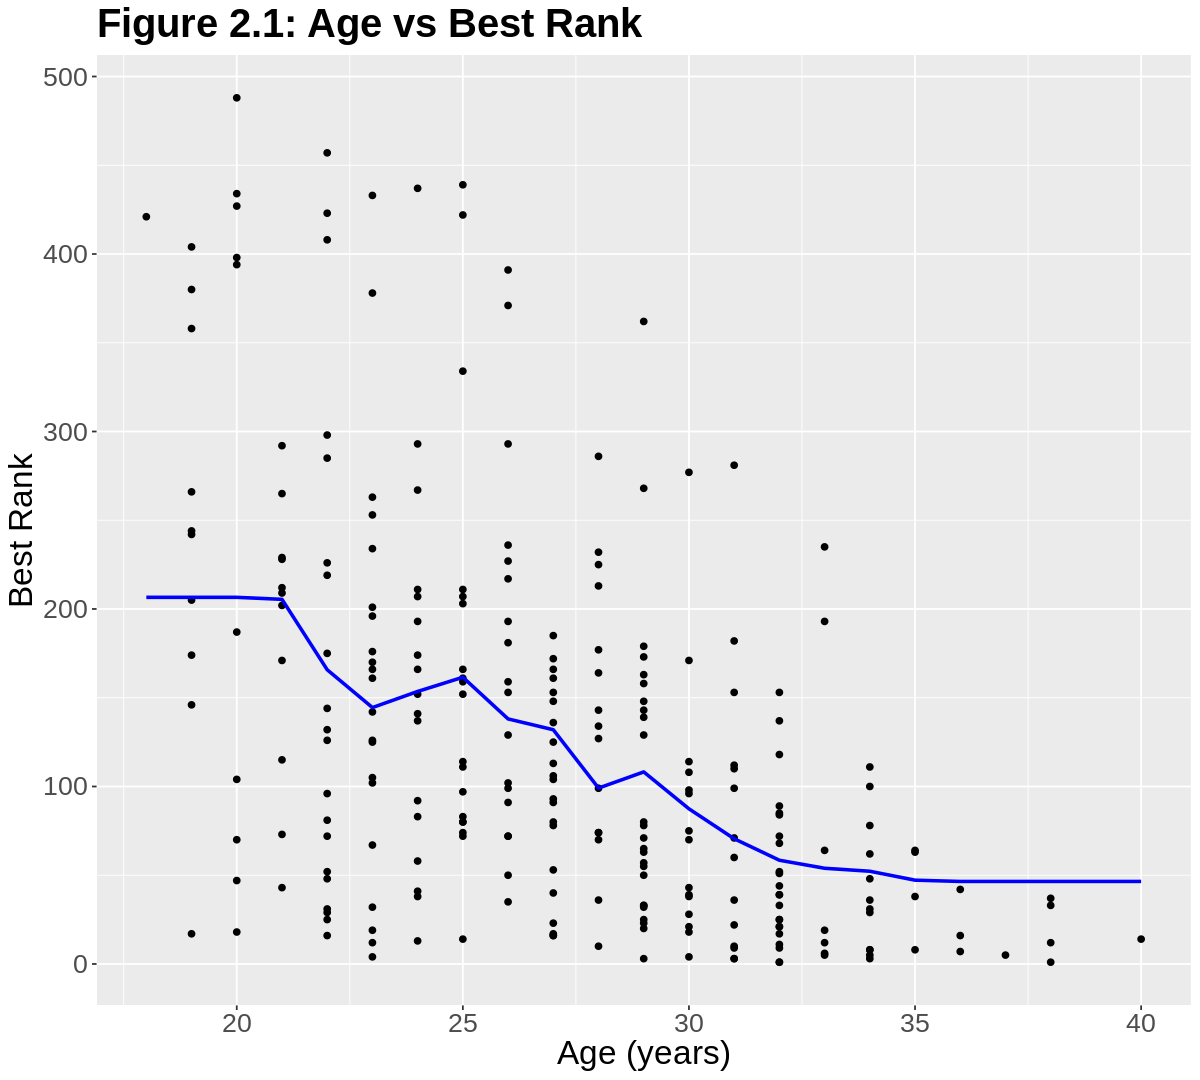

In [46]:
options(repr.plot.width = 10, repr.plot.height = 9)
age_train_info <- tennis_data_fit_age |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)

age_plot <- tennis_data_train |>
    ggplot(aes(x = Age, y = Best_Rank)) +
    geom_point() +
    geom_line(data = age_train_info, mapping = aes(x = Age, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Age (years)", y = "Best Rank", title = "Figure 2.1: Age vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
    
    
age_plot



Now we will do the same analysis for the other three predictors to determine their RMSPE

#### Model 2: Current Rank as the only predictor

Here is the model using Current Rank:

In [49]:

tennis_data_workflow_cr <- workflow() |>
    add_recipe(tennis_data_recipe_cr) |>
    add_model(tennis_data_specs)


cr_result <- tennis_data_workflow_cr |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(cr_result, n= 10)

kmin_cr_df <- cr_result |>
    filter(mean == min(mean))

kmin_cr <- kmin_cr_df |>
    pull(neighbors)

kmin_cr_df
kmin_cr

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,105.94471,5,7.103721,Preprocessor1_Model01
3,rmse,standard,88.83907,5,5.484232,Preprocessor1_Model02
5,rmse,standard,85.54846,5,5.144214,Preprocessor1_Model03
7,rmse,standard,82.54725,5,5.167075,Preprocessor1_Model04
9,rmse,standard,81.11714,5,4.551434,Preprocessor1_Model05
11,rmse,standard,79.12153,5,3.934727,Preprocessor1_Model06
13,rmse,standard,78.16090,5,3.739605,Preprocessor1_Model07
15,rmse,standard,77.48642,5,4.313357,Preprocessor1_Model08
17,rmse,standard,78.04330,5,4.694509,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,rmse,standard,76.91568,5,4.157166,Preprocessor1_Model13


[1] 25

Now we use k = 25 for our knn regression model and evaluate it using the testing data.

In [50]:
tennis_data_specs_cr <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_cr) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_cr <- workflow() |>
    add_recipe(tennis_data_recipe_cr) |>
    add_model(tennis_data_specs_cr) |>
    fit(data = tennis_data_train)

cr_pred <- tennis_data_fit_cr |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


cr_summary <- cr_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

cr_rmspe <- cr_summary |>
    pull(.estimate) |>
    round(digits = 0)


cr_summary
cr_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,72.92462


[1] 73

The RMSPE of the model with the Current Rank predictor is 73. Here is the visulatization of the model.

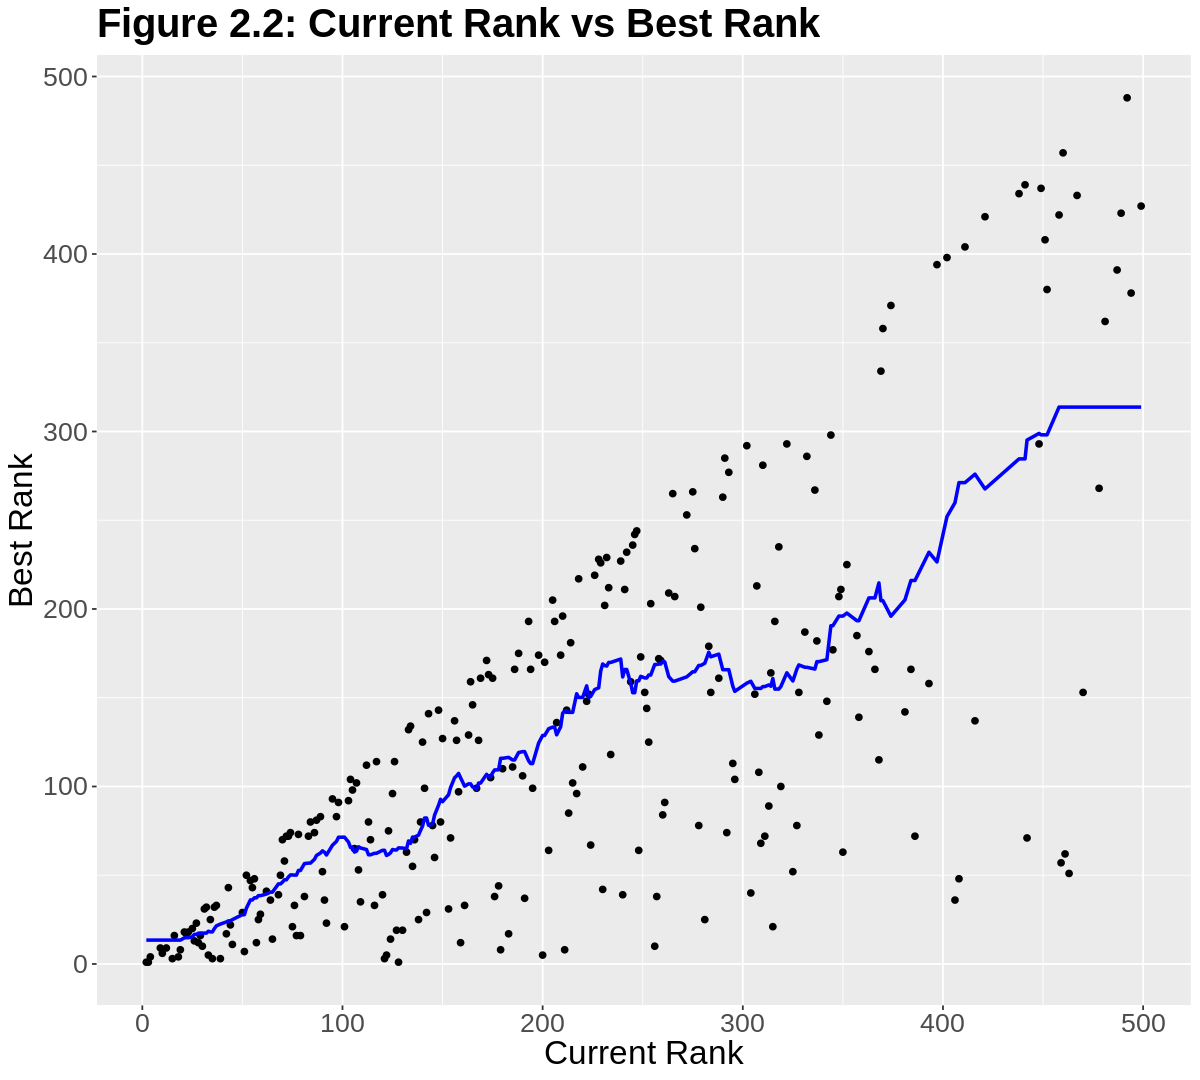

In [52]:
cr_train_info <- tennis_data_fit_cr |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)


cr_plot <- tennis_data_train |>
    ggplot(aes(x = Current_Rank, y = Best_Rank)) +
    geom_point() +
    geom_line(data = cr_train_info, mapping = aes(x = Current_Rank, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Current Rank", y = "Best Rank", title = "Figure 2.2: Current Rank vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
    
cr_plot



#### Model 3: Prize Money as the only predictor

Here is the model using only Prize Money as the predictor.

In [61]:

tennis_data_workflow_pm <- workflow() |>
    add_recipe(tennis_data_recipe_pm) |>
    add_model(tennis_data_specs)


pm_result <- tennis_data_workflow_pm |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(pm_result, n= 10)

kmin_pm_df <- pm_result |>
    filter(mean == min(mean))

kmin_pm <- kmin_pm_df |>
    pull(neighbors)

kmin_pm_df
kmin_pm

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,59.08262,5,1.725703,Preprocessor1_Model01
3,rmse,standard,52.58521,5,4.321615,Preprocessor1_Model02
5,rmse,standard,51.19259,5,3.488825,Preprocessor1_Model03
7,rmse,standard,52.67910,5,3.408247,Preprocessor1_Model04
9,rmse,standard,53.96396,5,3.364699,Preprocessor1_Model05
11,rmse,standard,55.58721,5,3.387390,Preprocessor1_Model06
13,rmse,standard,56.87358,5,3.275470,Preprocessor1_Model07
15,rmse,standard,57.80556,5,3.360447,Preprocessor1_Model08
17,rmse,standard,59.36966,5,3.378335,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,rmse,standard,51.19259,5,3.488825,Preprocessor1_Model03


[1] 5

The optimal number of neighbors 5.

In [62]:
tennis_data_specs_pm <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_pm) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_pm <- workflow() |>
    add_recipe(tennis_data_recipe_pm) |>
    add_model(tennis_data_specs_pm) |>
    fit(data = tennis_data_train)

pm_pred <- tennis_data_fit_pm |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


pm_summary <- pm_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")


pm_rmspe <- pm_summary |>
    pull(.estimate) |>
    round(digits = 0)


pm_summary
pm_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,52.19929


[1] 52

The RMSPE of the model with the Prize Money predictor is 52. Here is the visulatization of the model.

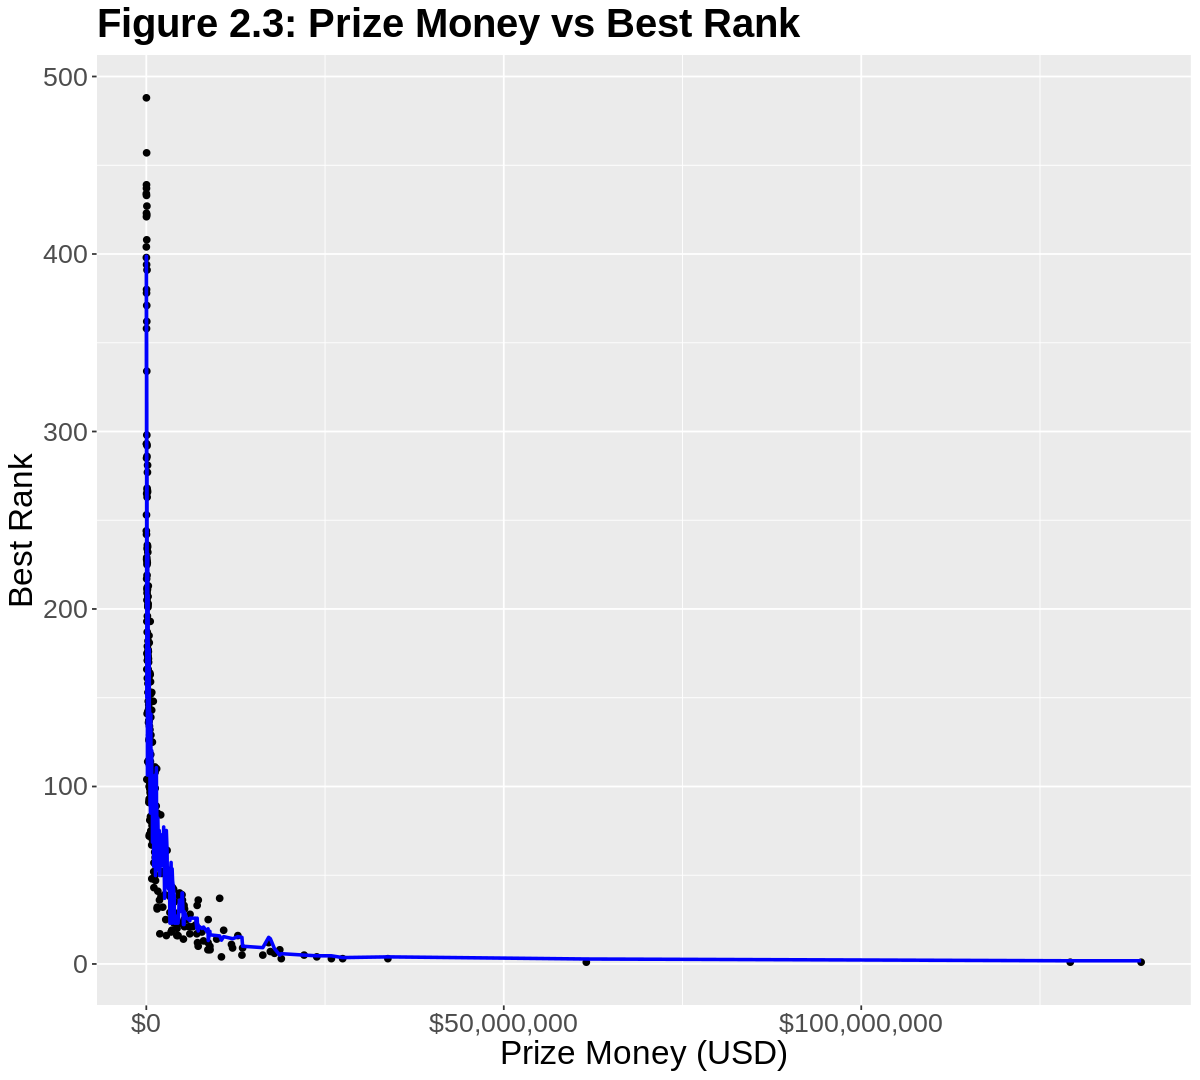

In [55]:
pm_train_info <- tennis_data_fit_pm |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)

pm_plot <- tennis_data_train |>
    ggplot(aes(x = Prize_Money, y = Best_Rank)) +
    geom_point() +
    geom_line(data = pm_train_info, mapping = aes(x = Prize_Money, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Prize Money (USD)", y = "Best Rank", title = "Figure 2.3: Prize Money vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold")) +
    scale_x_continuous(labels = dollar_format())
    
pm_plot


#### Model 4: Seasons Played as the only predictor

Here is the model using only Seasons Played:

In [63]:

tennis_data_workflow_seasons <- workflow() |>
    add_recipe(tennis_data_recipe_seasons) |>
    add_model(tennis_data_specs)


seasons_result <- tennis_data_workflow_seasons |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(seasons_result, n= 10)

kmin_seasons_df <- seasons_result |>
    filter(mean == min(mean))

kmin_seasons <- kmin_seasons_df |>
    pull(neighbors)

kmin_seasons_df
kmin_seasons

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,108.03627,5,6.788574,Preprocessor1_Model01
3,rmse,standard,99.43956,5,8.229192,Preprocessor1_Model02
5,rmse,standard,95.36534,5,6.015721,Preprocessor1_Model03
7,rmse,standard,89.00585,5,5.739111,Preprocessor1_Model04
9,rmse,standard,84.70953,5,6.226638,Preprocessor1_Model05
11,rmse,standard,80.14530,5,5.235621,Preprocessor1_Model06
13,rmse,standard,77.15023,5,4.980152,Preprocessor1_Model07
15,rmse,standard,76.57611,5,4.893486,Preprocessor1_Model08
17,rmse,standard,75.15444,5,4.375035,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,rmse,standard,72.2086,5,4.796237,Preprocessor1_Model18


[1] 35

Now we use k = 35 to make our model.

In [27]:
tennis_data_specs_seasons <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_seasons) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_seasons <- workflow() |>
    add_recipe(tennis_data_recipe_seasons) |>
    add_model(tennis_data_specs_seasons) |>
    fit(data = tennis_data_train)

seasons_pred <- tennis_data_fit_seasons |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


seasons_summary <- seasons_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

seasons_rmspe <- seasons_summary |>
        pull(.estimate) |>
    round(digits = 0)

seasons_summary
seasons_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,79.11269


[1] 79

The RMSPE of the model with the Seasons Played predictor is 79. Here is the visulatization of the model.

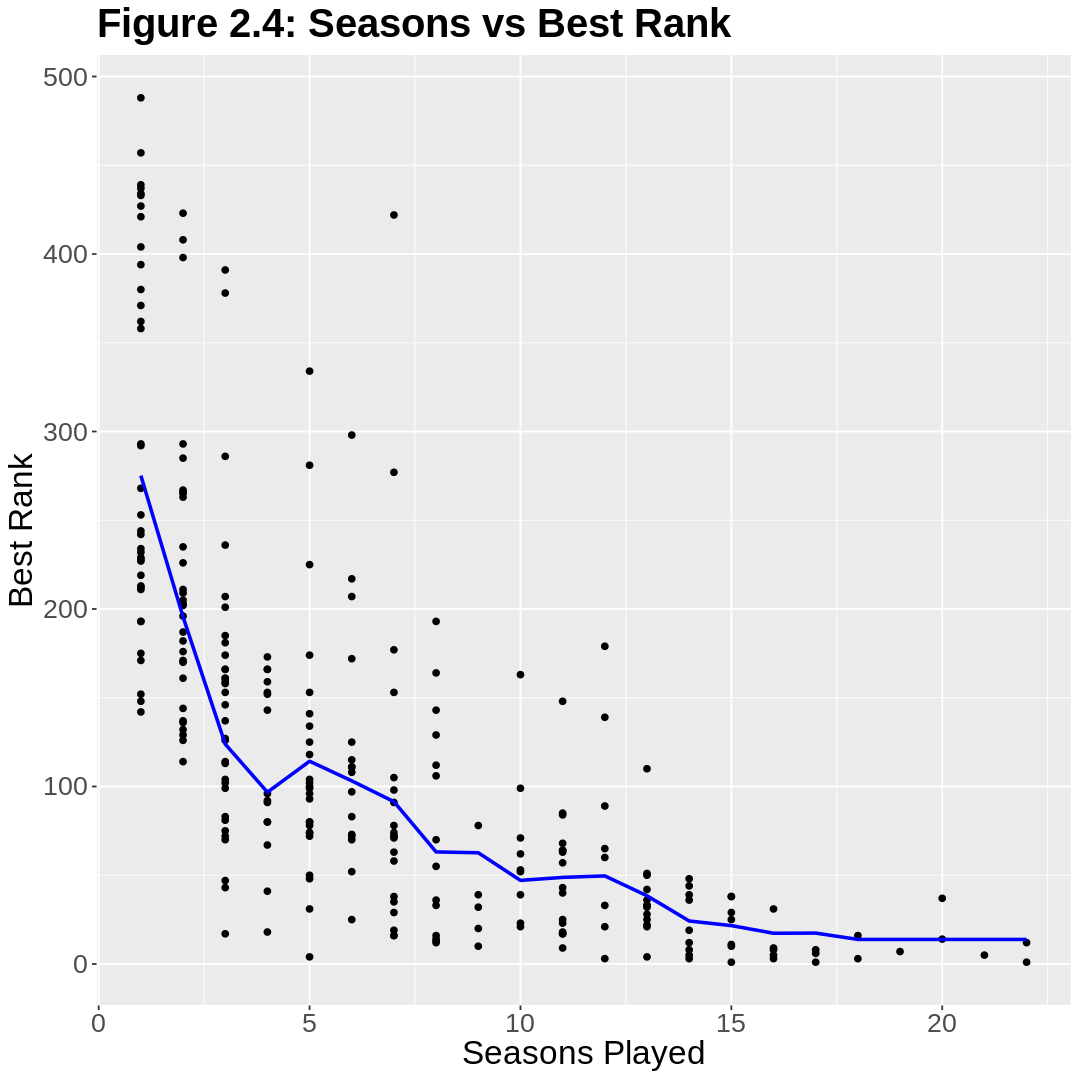

In [28]:
seasons_train_info <- tennis_data_fit_seasons |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)

seasons_plot <- tennis_data_train |>
    ggplot(aes(x = Seasons, y = Best_Rank)) +
    geom_point() +
    geom_line(data = seasons_train_info, mapping = aes(x = Seasons, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Seasons Played", y = "Best Rank", title = "Figure 2.4: Seasons vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
    
seasons_plot

#### Model 5: Using All four Predictors 

Now we will make a model which uses all the predctiors variables.

In [57]:
tennis_data_workflow <- workflow() |>
    add_recipe(tennis_data_recipe) |>
    add_model(tennis_data_specs)


result <- tennis_data_workflow |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(result, n= 10)

kmin_df <- result |>
    filter(mean == min(mean))

kmin <- kmin_df |>
    pull(neighbors)

kmin_df
kmin

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,57.22071,5,4.195503,Preprocessor1_Model01
3,rmse,standard,45.27689,5,4.718253,Preprocessor1_Model02
5,rmse,standard,44.96324,5,3.578959,Preprocessor1_Model03
7,rmse,standard,43.85882,5,4.000817,Preprocessor1_Model04
9,rmse,standard,44.66169,5,4.481041,Preprocessor1_Model05
11,rmse,standard,44.51169,5,4.966761,Preprocessor1_Model06
13,rmse,standard,45.60532,5,4.977970,Preprocessor1_Model07
15,rmse,standard,46.69601,5,4.526995,Preprocessor1_Model08
17,rmse,standard,47.16510,5,4.489455,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,43.85882,5,4.000817,Preprocessor1_Model04


[1] 7

Now we will use k = 9 to train the model.

In [31]:
tennis_data_specs_min <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit <- workflow() |>
    add_recipe(tennis_data_recipe) |>
    add_model(tennis_data_specs_min) |>
    fit(data = tennis_data_train)

pred <- tennis_data_fit |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


summary <- pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

all_rmspe <- summary |>
    pull(.estimate) |>
    round(digits = 0)

summary
all_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,48.617


[1] 49

The RMSPE of the model using all 4 predictors was 49.

### Results

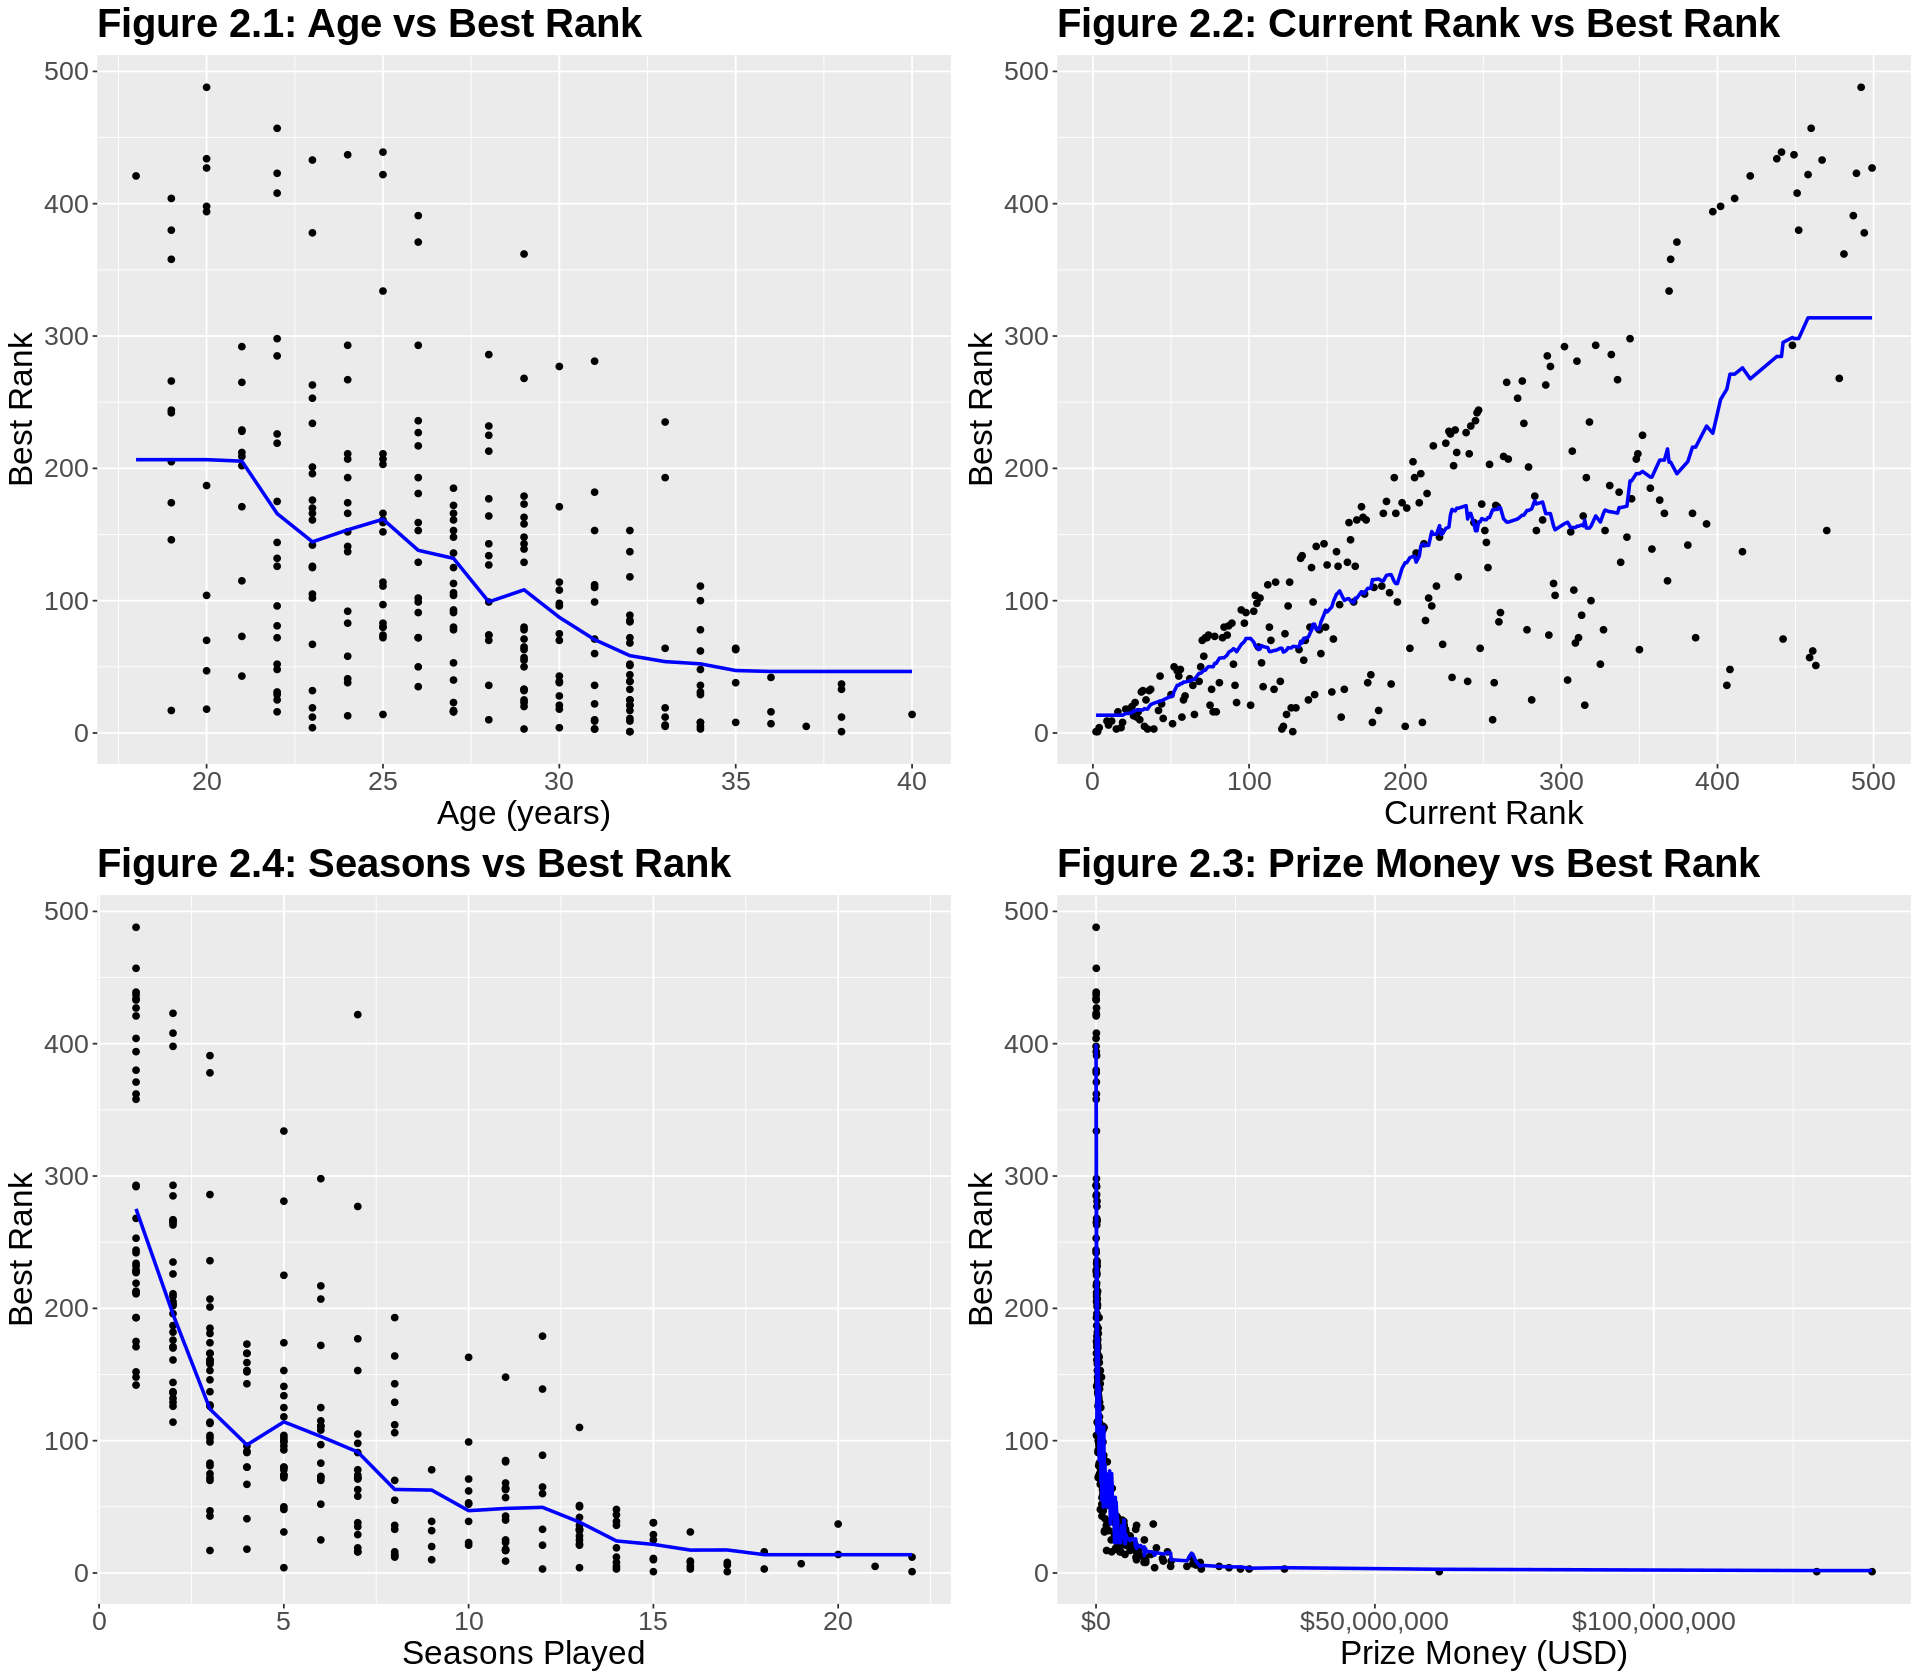

In [64]:
options(repr.plot.width = 16, repr.plot.height = 14)

plot_grid(age_plot, cr_plot, seasons_plot, pm_plot)

In [65]:
RMSPE <- c (age_rmspe, cr_rmspe, pm_rmspe, seasons_rmspe, all_rmspe)

model <- c ("Age", "Current Rank", "Prize Money", "Seasons Played", "Final Model")

number_Of_Neighbors <- c(kmin_age, kmin_cr, kmin_pm, kmin_seasons, kmin)

comparison_df <- data.frame(model, RMSPE,numberOfNeighbors) |>
    arrange(RMSPE)

comparison_df

model,RMSPE,numberOfNeighbors
<chr>,<dbl>,<dbl>
Final Model,49,9
Prize Money,52,3
Current Rank,73,27
Seasons Played,79,23
Age,92,53


In [68]:
new_obs <- tibble(Age = 27, Current_Rank = 150, Seasons = 5, Prize_Money = 15000)

pred33 <- tennis_data_fit |>
    predict(new_obs)
    
pred33

.pred
<dbl>
109.5556


Our comparisson data frame shows that our final model which used the recipe with all 4 predictors had the lowest RMSPE. This suggests that considering all 4 predictors provides a more accurate result than considering each of them individually. Our final model used 9 neighbors for the prediction which was higher than Prize Money (k = 3), which is likely because of the significant outliers in Prize Money, but it was lower than all other predictors k value. Using only Age as the predictor results in the highest error margin (92) which indicates that it is not as good of a predictors on its own. One the other hand, using Prize Money as the only predator results in a more accurate prediction which could be due to its stronger relationship with best rank (it can be seen in figure 2.3). The mean Best Rank was 127.7684 and the median was 99 out of 500 total ranks. Our RMSPE was 49 which shows that our model is not extremely acccurate and could be improved, but it's an acceptable margin of error.

### Discussion

As we had expected the final model with all 4 predictors gave the most accurate result when predicting best rank

### References